# Лабораторная №2

**Цель работы**: построить модели линейной классификации и регрессии.

**Инструменты**: модели классификации (SGDClassifier) и регрессии (SGDRegressor) из пакета scikit-learn.

## Подготовка данных

Подключим необходимые библиотеки:
- `numpy` и `pandas` для работы с массивами данных
- `matplotlib` для визуализаций
- `sklearn` для импорта исследуемых моделей, метрик, поиска оптимальных гиперпараметров и разделения данных на обучающую и тестовую выборки

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, f1_score

Используем игнорирование ошибок:

In [104]:
import warnings
warnings.simplefilter("ignore")

Загрузим обработанные данные в переменные:
- `advertising_dataset` - датасет для регрессионной задачи предсказания продажи товара в зависимости от средств, потраченных на его рекламу
- `heart_dataset` - датасет для задачи классификации (наличия болезни) по информации о физическом тестировании пациентов

In [105]:
advertising_dataset = pd.read_csv("Advertising_processed.csv")
heart_dataset = pd.read_csv("Heart_processed.csv")

Разобьём их на обучающую и тестовую выборки (целевая переменная в регрессии - `sales`, в классификации - `target`):

In [106]:
# выделение целевой переменной
regr_x, regr_y = advertising_dataset.drop(columns="sales"), advertising_dataset["sales"]
clf_x, clf_y = heart_dataset.drop(columns="target"), heart_dataset["target"]

# разбиение в соотношении 80/20
regr_x_train, regr_x_test, regr_y_train, regr_y_test = train_test_split(regr_x, regr_y, train_size=0.8, random_state=0)
clf_x_train, clf_x_test, clf_y_train, clf_y_test = train_test_split(clf_x, clf_y, train_size=0.8, random_state=0)

## Сравнение архитектур (регрессия)

Теперь рассмотрим различные архитектуры регрессора `SGDRegressor`:
1. Минимизируемая функции потерь (гиперпараметр `loss`) в общем виде задаются формулой ($l$ - количество данных)
    $$
    Q(w) = \frac{1}{l}\sum^l_{i=1} L(y_i, \hat{y}_i) = \frac{1}{l}\sum^l_{i=1}q_i(w)
    $$
    - При `squared_error` в качестве функции ошибки на отдельном тесте ($q_i$) берётся $q_i(w) = (y_i(w) - \hat{y}_i)^2$. Интересна тем, что является чисто дифференцируемой, однако стимулирует модель подстраиваться под выбросы.
    - При параметре `huber` в окрестности 0 используется квадратичное отклонение, помогая искать оптимальное значение функции за счёт существования производной, при удалении - модуль, помогающий с выбросами.
    $$
        q_i =
        \begin{cases}
        \frac{1}{2}(y_i - \hat{y}_i)^2, &  |y_i - \hat{y}_i| < \delta \\
        \delta (|y_i - \hat{y}_i| - \frac{1}{2}\delta) , & |y_i - \hat{y}_i| \ge \delta
        \end{cases}
    $$
    - При `epsilon_insensitive` игнорируются ошибки, меньшие заданного $\epsilon$
    $$
        q_i =
        \begin{cases}
        0, & |y_i - \hat{y}_i| < \epsilon \\
        |y_i - \hat{y}_i| - \epsilon, & |y_i - \hat{y}_i| \ge \epsilon
        \end{cases}
    $$
2. Для борьбы с переобучением вводится штраф за большие веса модели (гиперпараметр `penalty`), к функции потерь дополнительно добавляется слагаемое (регуляризация)
    $$
    \hat{Q}(w) = Q(w) + \alpha R(w)
    $$
    - `l2` улучшает рельеф функции потерь, так как является выпуклой и дифференцируемой: 
    $$
    R(w) = \frac{1}{2} \|w\|^2
    $$ 
    - `l1` способно занулять часть весов 
    $$
    R(w) = \|w\|_1
    $$
    - `elasticnet` комбинирует обе регуляризации (при $\beta = 0$ получаем L2-регуляризацию, при $\beta = 1$ - L1-регуляризацию)
    $$
    R(w) = \beta \|w\|_1 + \frac{1 - \beta}{2} \|w\|^2
    $$
3. Контролировать регуляризацию помогает коэффициент $\alpha$ (гиперпараметр `alpha`). Чем он больше - тем сильнее регуляризация.

С помощью `GridSearchCV` найдём лучшие гиперпараметры через перебор их комбинаций и кросс-валидацию (параметр `cv` задаёт количество разбиений):

In [107]:
# задаём гиперпараметры
param_grid_regr = {
    "loss": ["squared_error", "huber", "epsilon_insensitive"],
    "penalty": ["l1", "l2", "elasticnet"],
    "alpha": [0.0001, 0.001, 0.01, 0.1]
}

# для обеспечения повторяемости зададим random_state
sgd_regr = SGDRegressor(random_state=0)
grid_regr = GridSearchCV(estimator=sgd_regr, param_grid=param_grid_regr, cv=10)

# перебираем комбинации для выбора наилучшей по качеству
grid_regr.fit(regr_x_train, regr_y_train);

In [108]:
# выбор лучшей модели
best_regr = grid_regr.best_estimator_
print("Лучшие гиперпараметры для SGDRegressor:", grid_regr.best_params_)

Лучшие гиперпараметры для SGDRegressor: {'alpha': 0.01, 'loss': 'squared_error', 'penalty': 'l1'}


Проверим качество полученной модели на тестовой выборке с помощью различных метрик ($n$ - количество данных в тестовой выборке):
1. **Root Mean Squared Error (RMSE)** чувствительна к наличию выбросов
$$
\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

2. **Mean Absolute Error (MAE)** является более устойчивой, измеряет чистую среднюю ошибку в данных
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
$$

3. **Коэффициент детерминации**  
$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

In [109]:
# предсказание на тестовой выборке
y_pred_regr = best_regr.predict(regr_x_test)

# проверка качества
rmse = np.sqrt(mean_squared_error(regr_y_test, y_pred_regr))
mae = mean_absolute_error(regr_y_test, y_pred_regr)
r2  = r2_score(regr_y_test, y_pred_regr)

print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R^2: {r2:.3f}")

RMSE: 1.339, MAE: 1.096, R^2: 0.918


`SGDRegressor` позволяет обучаться на ходу, используя небольшие порции данных (батчи, полезные при большом количестве данных). Попробуем обучить модель с выбраными ранее гиперпараметрами этим способом, в качестве метрики будет использовать `r2-score`.

In [110]:
# задаём функции, каждый раз выдающую определённую порцию данных (batch)
def batch(X, y, n=1):
    l = len(X)
    for ndx in range(0, l, n):
        yield X[ndx:min(ndx + n, l)], y[ndx:min(ndx + n, l)]

In [111]:
def get_scores_for_batch_learning(model, score_func, x_train, 
                                  y_train, x_test, y_test, 
                                  n_batches=5, n_epochs=10, classes=None):
    scores = []
    for _ in range(n_epochs):
        batcherator = batch(x_train, y_train, n_batches)
        for (chunk_X, chunk_y) in batcherator:
            if classes:
                model.partial_fit(chunk_X, chunk_y, classes=classes)
            else:
                model.partial_fit(chunk_X, chunk_y)
            y_predicted = model.predict(x_test)
            scores.append(score_func(y_test, y_predicted))
    return scores

# получим r2-scores для количества эпох = 50
regr = SGDRegressor(random_state=0, **grid_regr.best_params_)
scores = get_scores_for_batch_learning(regr, r2_score, regr_x_train, regr_y_train, regr_x_test, regr_y_test, n_batches=10, n_epochs=50)
print("R2-score на последних итерациях:", *[round(score, 3) for score in scores[-5:]])

R2-score на последних итерациях: 0.74 0.74 0.741 0.741 0.741


Для наглядности также построим график обучения:

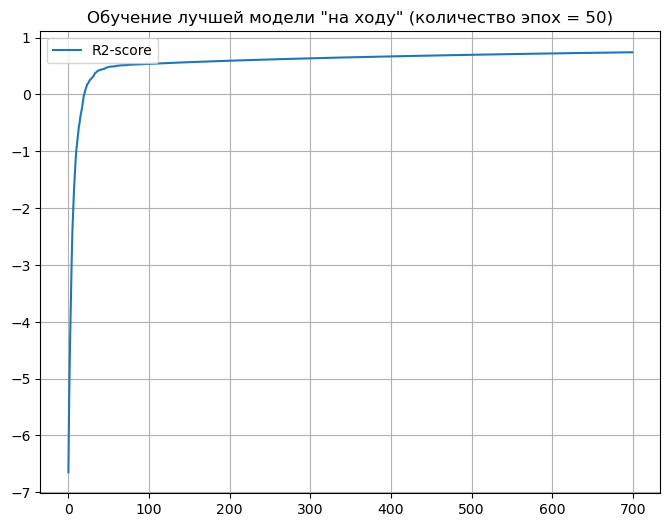

In [112]:
fig = plt.figure(figsize=(8, 6))

plt.plot(scores, label="R2-score")
plt.grid(True)
plt.legend()
plt.title('Обучение лучшей модели "на ходу" (количество эпох = 50)');

При желании количество эпох (прогонов обучающих данных по кругу) можно увеличить, иногда это позволяет добиться ещё более точной настройки, причём лучшей по значениям, чем при обычном обучении:

In [113]:
dn = 100
regr = SGDRegressor(random_state=0, **grid_regr.best_params_)
for n in range(100, 501, dn):
    scores = get_scores_for_batch_learning(regr, r2_score, regr_x_train, regr_y_train, regr_x_test, regr_y_test, n_batches=10, n_epochs=dn)
    print(f"R2-score на последних итерациях при количестве эпох = {n}:", *[round(score, 3) for score in scores[-5:]])

R2-score на последних итерациях при количестве эпох = 100: 0.831 0.831 0.831 0.831 0.831
R2-score на последних итерациях при количестве эпох = 200: 0.897 0.898 0.898 0.898 0.898
R2-score на последних итерациях при количестве эпох = 300: 0.92 0.92 0.92 0.92 0.92
R2-score на последних итерациях при количестве эпох = 400: 0.929 0.929 0.929 0.929 0.929
R2-score на последних итерациях при количестве эпох = 500: 0.933 0.933 0.933 0.933 0.933


## Сравнение архитектур (классификатор)

Рассмотрим модель классификации `SGDClassifier` с гиперпараметрами:
1. Функции потерь (гиперпараметр `loss`):
    - `perceptron`, линейно наказывающий ошибку:
        $$
        L(y, \hat{y}) =
        \begin{cases}
        0, & y \cdot \hat{y} > 0 \\
        -y \cdot \hat{y}, & y \cdot \hat{y} \le 0
        \end{cases}
        $$
    - `hinge`, поощряющий классификацию, где предсказание не просто правильное, но и на расстоянии $\ge$ 1:
        $$
        L(y, \hat{y}) = \max(0, 1 - y \cdot \hat{y})
        $$
    - `squared_hinge`, улучшающий гладкость `hinge`:
        $$
        L(y, \hat{y}) = \left( \max(0, 1 - y \cdot \hat{y}) \right)^2
        $$
2. Ранее рассмотренные регуляризации `l1`, `l2`, `elasticnet` (гиперпараметр `penalty`).
3. $\alpha$, их регулирующая (гиперпараметр `alpha`).

In [114]:
# задаём гиперпараметры
param_grid_clf = {
    "loss": ["perceptron", "hinge" , "squared_hinge"],
    "penalty": ["l1", "l2", "elasticnet"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
}

# задаём классификатор
sgd_clf = SGDClassifier(random_state=3)
grid_clf = GridSearchCV(estimator=sgd_clf, param_grid=param_grid_clf, cv=10)

# отбираем лучшую
grid_clf.fit(clf_x_train, clf_y_train);

In [115]:
# выбор лучшей модели
best_clf = grid_clf.best_estimator_
print("Лучшие гиперпараметры для SGDClassifier:", grid_clf.best_params_)

Лучшие гиперпараметры для SGDClassifier: {'alpha': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'}


Оценим качество модели с помощью различных метрик:
1. **Точность (accuracy)** проверяет количество правильно классифицированных объектов в зависимости от общего числа
$$
\text{Accuracy} = \frac{\text{TruePositive} + \text{TrueNegative}}{\text{TruePositive} + \text{TrueNegative} + \text{FalsePositive} + \text{FalseNegative}}
$$

2. Можем также посмотреть на **точность по опреденному классу (precision)**
$$
\text{Precision} = \frac{\text{TruePositive}}{\text{TruePositive} + \text{FalsePositive}}
$$

3. **Полнота (recall)** показывает долю найденных положительных объектов из всех положительных
$$
\text{Recall} = \frac{\text{TruePositive}}{\text{TruePositive} + \text{FalseNegative}}
$$

4. **F1-Score** совмещает в себе и precision и recall:
$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Так как перед нами стоит задача бинарной классификации, то удобно пользоваться следующей таблицей (здесь $y$ - целевая переменная, $\hat{y}$ - предсказанная нашей моделью):

|                    |$y=1$                 |$y=0$                    |
| ---                |---                   |---                      |
| $\widehat{y}=1$    |$\text{TruePositive}$ | $\text{FalsePositive}$  |
| $\widehat{y}=0$    |$\text{FalseNegative}$| $\text{TrueNegative}$   |



In [116]:
# предсказание на тестовой выборке
y_pred_clf = best_clf.predict(clf_x_test)

# отчёт по классификации на тестовой выборке
print(classification_report(y_pred_clf, clf_y_test))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.91      0.87      0.89        23

    accuracy                           0.88        43
   macro avg       0.88      0.88      0.88        43
weighted avg       0.88      0.88      0.88        43



Наконец попробуем обучение на ходу, но сейчас в задаче классификации с использованием `SGDClassifier` (в качестве метрики будем брать `f1-score`):

In [117]:
clf = SGDClassifier(random_state=0, **grid_clf.best_params_)

# получим f1-scores для количества эпох = 50
scores = get_scores_for_batch_learning(clf, f1_score, clf_x_train, clf_y_train, clf_x_test, clf_y_test, n_batches=10, n_epochs=50, classes=[0, 1])
print("f1-score на последней итерации:", *[round(score, 3) for score in scores[-1:]])

f1-score на последней итерации: 0.846


## Заключение
**Результаты и выводы**:
   - В задаче регрессии при использовании `SGDRegressor` лучшая модель (`alpha` = 0.01, `loss` = `squared_error`, `penalty` = `l1`) дала
        - **RMSE** = $1.339$
        - **MAE** = $1.096$
        - $R^2$ = $0.918$
   - В задаче классификации при использовании `SGDClassifier` лучшая модель (`alpha` = 0.001, `loss` = `squared_hinge`, `penalty` = `l1`) дала             
        - На первом классе **Precision** = $0.86$, **Recall**  = $0.90$,  **F1** = $0.88$
        - На втором классе **Precision** = $0.91$, **Recall**  = $0.87$,  **F1** = $0.89$
        - Получаем средние **Precision** = $0.88$, **Recall**  = $0.88$,  **F1** = $0.88$
   - minibatch optimization показало себя не хуже обычного обучения:
        - В задаче регрессии при количестве эпох = 500 удалось добиться $R^2 = 0.933$
        - В задаче классификации при количестве эпох = 50 удалось получить $F1 = 0.846$
   - Прочие, более сложные модели машинного обучения требуют дальнейшего анализа для оценки их эффективности относительно приведенных.